In [10]:
from simenvs.hcwsim import HCWLTIDynamics
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers.default='notebook'
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import argparse
import plotly.offline as py

np.random.seed(0)

# Dynamics
Initialize the HCW Dynamics

In [11]:
sim = HCWLTIDynamics()
# print("A\n",sim.A)
# print("B\n",sim.B)
# print("C\n",sim.C)
# print("D\n",sim.D)

# Initial State

In [12]:
x0 = np.array([10.0, 10.0, 10.0, 0.0, 0.0, 0.0])
# print(x0)

# Define the Goal

In [13]:
def goal_reached(s, tol = 0.01):
    return(np.linalg.norm(s) < tol)

# Dynamic Programming Solution
Iterate K and P until convergence

In [15]:
Q = np.eye(6)
Qf = Q
R = 1 * np.eye(3)
P_now = Qf # Qf
K_now = 0
P_prev = np.zeros((6,6))
K_prev = 0
A = sim.A
B = sim.B

while not np.allclose(P_now,P_prev):
    P_now = np.copy(P_prev)
    K_now = np.copy(K_prev)
    K_prev = - np.linalg.inv((np.transpose(B).dot(P_now).dot(B) + R)).dot(np.transpose(B)).dot(P_prev).dot(A)
    P_prev = Q + np.transpose(A).dot(P_prev).dot(A) - np.transpose(A).dot(np.transpose(P_prev)).dot(B).dot(np.linalg.inv(np.transpose(B).dot(P_prev).dot(B) + R)).dot(np.transpose(B)).dot(P_prev).dot(A)
#     P_prev = Q + np.dot(np.transpose(K_now),np.dot(R,K_now)) + np.transpose(A - np.dot(B, K_now))*P_now*(A - np.dot(B, K_now))
#     K_prev = np.dot(np.linalg.inv(R + np.dot(np.transpose(B), np.dot(P_now, B))), np.dot(np.transpose(B), np.dot(P_now, A)))
print("K\n", K_prev)
print("P\n", P_prev)


K
 [[-9.94180974e-01  2.00167947e-03 -0.00000000e+00 -2.22805942e+00
  -2.38420189e-05 -0.00000000e+00]
 [-2.00168851e-03 -9.94173362e-01 -0.00000000e+00  1.88204380e-05
  -2.22805264e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -9.94172840e-01 -0.00000000e+00
  -0.00000000e+00 -2.22805219e+00]]
P
 [[ 2.24074916e+02  2.48332979e-04  0.00000000e+00  1.99951564e+02
   4.03700025e-01  0.00000000e+00]
 [ 2.48332979e-04  2.24074231e+02  0.00000000e+00 -4.02580945e-01
   1.99950034e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.24073733e+02  0.00000000e+00
   0.00000000e+00  1.99949936e+02]
 [ 1.99951564e+02 -4.02580945e-01  0.00000000e+00  4.47611640e+02
   1.75835096e-03  0.00000000e+00]
 [ 4.03700025e-01  1.99950034e+02  0.00000000e+00  1.75835096e-03
   4.47610275e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.99949936e+02  0.00000000e+00
   0.00000000e+00  4.47610186e+02]]


# Stability
Find the eigenvalues of (A-BK) and check that their norm is less than 1

In [16]:
evals = np.linalg.eigvals(sim.A + sim.B.dot(K_prev))
for i in range(len(evals)):
    norm = np.linalg.norm(evals[i])
    stable = norm < 1
    if stable:
        print(norm, "    Stable")
    else:
        print(norm, "    UNSTABLE")

0.9944238566905229     Stable
0.9944238566905229     Stable
0.9944296565259796     Stable
0.9944296565259796     Stable
0.9944267662176213     Stable
0.9944267662176213     Stable


# Demo

In [17]:
def demo(K):
    S = [x0]
    while True:
        s_new = sim.step(S[-1],np.dot(K, S[-1]))
        S.append(s_new)
        if goal_reached(s_new):
            return S
S = demo(K_prev)

# Plot

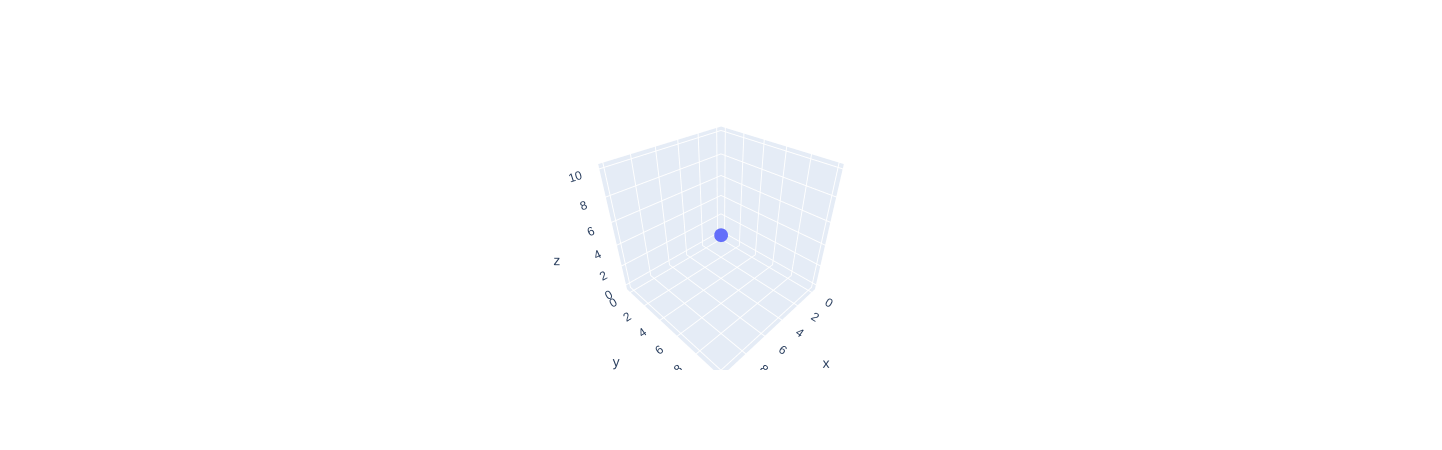

In [19]:
X = [x[0] for x in S]
Y = [x[1] for x in S]
Z = [x[2] for x in S]
# print(S[0])
fig = go.Figure(data=go.Scatter3d(x=X, y=Y, z=Z, mode='markers'))
# plot_url = py.plot(fig, filename='lqr.html', include_mathjax='cdn')
fig.show()

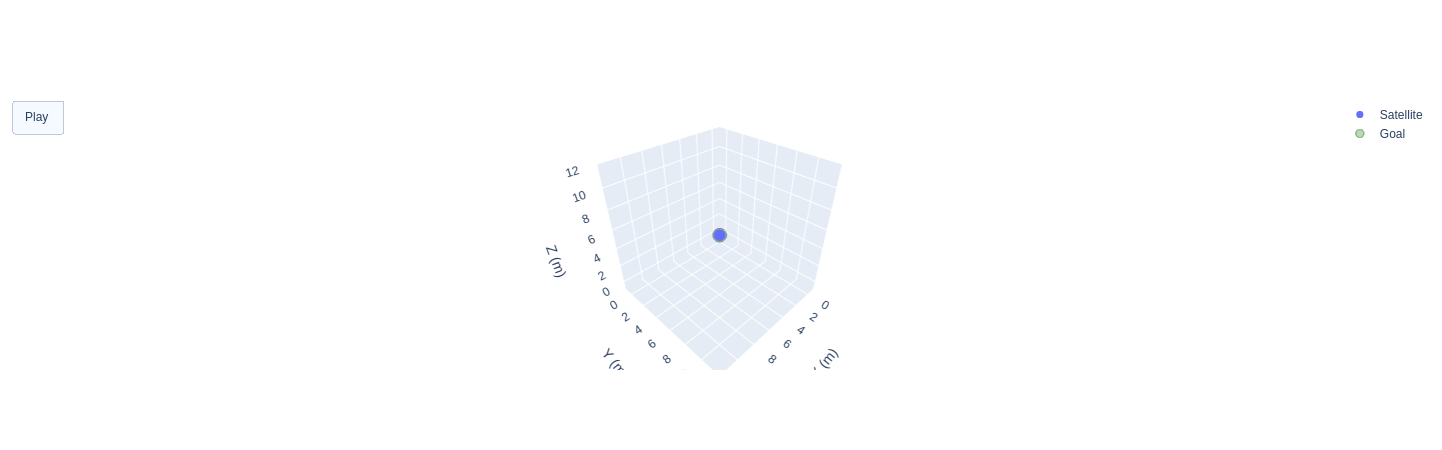

1287


In [21]:
# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": [],
    "transition": {}
}

# populate the layout
fig_dict["layout"]["xaxis"] = {"range": [0, 12]}
fig_dict["layout"]["yaxis"] = {"range": [0, 12]}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 0.01, "redraw": True},"transition": {"duration":0.01}}])])]

# make data
data_dict = {
    "type": 'scatter3d',
    "x": [X[0]],
    "y": [Y[0]],
    "z": [Z[0]],
    "name": "Satellite",
    "mode": "markers",
    "marker": {
        "sizemode": "area",
        "size": 7
    }
}
fig_dict["data"].append(data_dict)

# make frames
for i in np.arange(0, len(X), 8):
    frame = {"data": []}
    data_dict = {
        "type": 'scatter3d',
        "x": [X[i]],
        "y": [Y[i]],
        "z": [Z[i]],
        "mode": "markers",
        "marker": {
            "sizemode": "area",
            "size": 4
        }
    }
    frame["data"].append(data_dict)
    fig_dict["frames"].append(frame)

fig = go.Figure(fig_dict)
fig.add_trace(go.Scatter3d(x=[0],
                  y=[0],
                  z=[0],
                  mode='markers',
                  name='Goal',
                  marker=dict(symbol='circle',
                                size=8,
                                color='#54ca41',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  hoverinfo='text',
                  opacity=0.5
                  ))
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 10
fig.update_layout(
    width = 1800,
    scene = dict( xaxis = dict(nticks = 10, range=[-1, 12]), 
    yaxis = dict(nticks = 10,range=[-1, 12]),
    zaxis = dict(nticks = 10,range=[-1,12]), 
    aspectratio=dict(x=1,y=1,z=1),
                xaxis_title="X (m)", yaxis_title="Y (m)", zaxis_title="Z (m)")
)
# plot_url = py.plot(fig, filename='lqr_animation.html', include_mathjax='cdn')
fig.show()
print(len(X))